# Using Slisemap on the *Auto MPG* dataset

In this notebook we will demonstrate how to use Slisemap on the *Auto MPG* dataset. Slisemap can be used directly on the dataset itself, but here we will train a black box regressor and use Slisemap to interpret the behaviour of a black box model.

In [1]:
import sys

import numpy as np
import pandas as pd

from pathlib import Path
from urllib.request import urlretrieve

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

sys.path.insert(0, "..")

from slisemap import Slisemap

### Objectives

These are the objectives of this notebook:

- Demonstrate how Slisemap is used.
- Document the most useful parameters.
- Display the various plots that Slisemap provides.
- Show how Slisemap provides insights about the data.
- Use Slisemap to highlight ambiguities in the local model selection.
- Demonstrate how Slisemap handles new, unseen data.

## Slisemap Model Caching

To reduce execution times, we provide dumps of pretrained Slisemap models. If you want to train them yourself instead, please comment out the following lines and remove the `cache` directory in this `examples` folder.

In [2]:
for cached in ["sm-01.sm"]:
    path = Path("cache") / cached
    path.parent.mkdir(exist_ok=True, parents=True)
    if not path.exists():
        urlretrieve(
            f"https://raw.githubusercontent.com/edahelsinki/slisemap/data/examples/cache/{cached}",
            path,
        )

## Data 

The *Auto MPG* dataset is a multivariate real-valued dataset with eight attributes describing fuel consumption -related properties of 398 distinct automobiles. We use mpg (miles per gallon) as the target variable and we have additionally removed 6 data items that had missing values. The data consists of 3 discrete and 5 continuous attributes (one of which is mpg) and it is available through UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/auto+mpg

In [3]:
"""
Load the AutoMPG dataset (download it if necessary).
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml].
 Irvine, CA: University of California, School of Information and Computer Science.
Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
 In Proceedings on the Tenth International Conference of Machine Learning, 236-243,
 University of Massachusetts, Amherst. Morgan Kaufmann.
"""
path = Path("data") / "auto-mpg.data"
path.parent.mkdir(exist_ok=True, parents=True)
if not path.exists():
    urlretrieve(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data",
        path,
    )
auto_mpg = pd.read_csv(
    path,
    names=[
        "mpg", "cylinders", "displacement", "horsepower", "weight",
        "acceleration", "year", "origin", "carname",
    ],
    delim_whitespace=True,
    na_values=["?"],
)

In [4]:
X0 = auto_mpg[[
    "cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin",
]]
y0 = auto_mpg["mpg"]

# Split and one-hot encode the origin into USA vs Europe vs Japan
X0 = np.concatenate(
    (X0.values[:, :-1].astype(float), np.eye(3)[X0["origin"].values.astype(int) - 1]), axis=1,
)
y0 = y0.values

# X0 contains the covariates, y0 is the target variable and names are column names.
mask = ~np.isnan(X0[:, 2])
X0 = X0[mask]
y0 = y0[mask]

names = list(auto_mpg.columns[1:-2]) + ["origin USA", "origin Europe", "origin Japan"]

In [5]:
pd.DataFrame(np.concatenate([y0.reshape((-1,1)), X0], axis=1), columns=["mpg"]+names)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin USA,origin Europe,origin Japan
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,0.0,0.0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,0.0,0.0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,0.0,0.0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,0.0,0.0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4.0,140.0,86.0,2790.0,15.6,82.0,1.0,0.0,0.0
388,44.0,4.0,97.0,52.0,2130.0,24.6,82.0,0.0,1.0,0.0
389,32.0,4.0,135.0,84.0,2295.0,11.6,82.0,1.0,0.0,0.0
390,28.0,4.0,120.0,79.0,2625.0,18.6,82.0,1.0,0.0,0.0


In [6]:
# X and y are normalised by `sklearn.preprocessing.StandardScaler`.
X = np.concatenate([StandardScaler().fit_transform(X0[:,:-3]), X0[:,-3:]], axis=1)
y = StandardScaler().fit_transform(y0[:, None])
# We also remove ten random datapoints from the data for testing later.
X, X_test, y, y_test, X0, _, y0, _ = train_test_split(
    X, y, X0, y0, test_size=7, random_state=42
)

### Black box model

Instead of simply running Slisemap on the data itself, we showcase how it can be utilised to provide explanations on a black box model. Typically a black box model is produced *via* some machine learning algorithm and the inner workings of the resulting model are too complicated for a human to understand. Here we train and use a random forest from `sklearn.ensemble.RandomForestRegressor`.

In [7]:
random_forest = RandomForestRegressor(random_state=42).fit(X, y.ravel())
y2 = random_forest.predict(X)

## Slisemap

When a user creates a new Slisemap object, they have various options available. The only required variables are the covariates $\bf X$ and the target values $\bf y$, but there are a number of optional arguments, some of which are detailed below:

    X[i,j]:      The data covariates in an array format (here i=392,j=9).
    y[i]:        The target variable in an array format (here i=392).
    radius:      The radius of the embedding Z. Defaults to 3.5.
    d:           The number of embedding dimensions. Defaults to 2.
    lasso:       Lasso regularisation coefficient (penalty term related to absolute values). Defaults to 0.0.
    ridge:       Ridge regularisation coefficient (penalty term related to squared values). Defaults to 0.0.
    local_model: Prediction function for the local white box models. Defaults to linear_regression.
    local_loss:  Loss function for the local white box models. Defaults to least_squares.
    intercept:   Should an intercept term be added to local models. Defaults to True.
    cuda:        Use cuda if available. Defaults to True if the data is not too small.

Next we will create a Slisemap object and optimise the solution. Since this example takes a few minutes to optimise, we instead load a precalculated Slisemap object from disk.

In [8]:
path = Path("cache") / "sm-01.sm"
path.parent.mkdir(exist_ok=True, parents=True)

if Path(path).exists():
    sm = Slisemap.load(path)
else:
    # Create a Slisemap object with lasso regularisation
    sm = Slisemap(X, y2, lasso=0.01, random_state=42)
    # Optimise the solution
    %time sm.optimise()

    sm.cpu()
    sm.save(path)

print(f"Loss: {sm.value()}")

CPU times: user 2min 22s, sys: 305 ms, total: 2min 22s
Wall time: 24.6 s
Loss: 9.15556812286377


Note that the optimisation of the solution is separate from the creation. This allows us to tweak the parameters (if necessary) and re-optimise the solution, without starting from the beginning.

### Visualisations

Slisemap comes with some built-in visualisation plots. Some optional argumens are detailed below:

    title:      Title of the plot. Optional and defaults to "".
    clusters:   Optional integer which, if given, clusters the local models into this many clusters.
    bars:       Optional True/False or integer. If True, plot the coefficients as a bar plot and if 
                an integer, plot that many of the most prominent variables.
    jitter:     Add random (Gaussian) noise to the scatterplot, to show points that are on top of
                each other. Defaults to 0.0.
    variables:  Optional list of variable names.

The default plot looks like this:

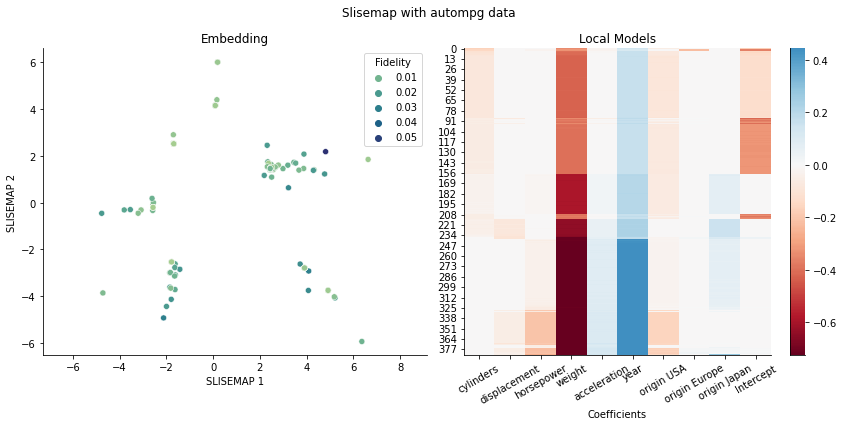

In [9]:
sm.plot(title="Slisemap with autompg data", variables=names)

On the left is the two-dimensional embedding, with colour based on the fidelity of the local model (i.e. how well it predicts the corresponding data item). On the right is a matrix representation of the coefficients of the local models, sorted such that the points left-to-right in the embedding correspond to rows top-to-bottom of the local models. The coefficients are the dataset attributes and the intercept term.

To make the investigation of the local models easier we cluster the coefficients using `sklearn.cluster.KMeans` and color-code the embedding based on the clustering. We also add some jitter to the embedding to show overlapping points:

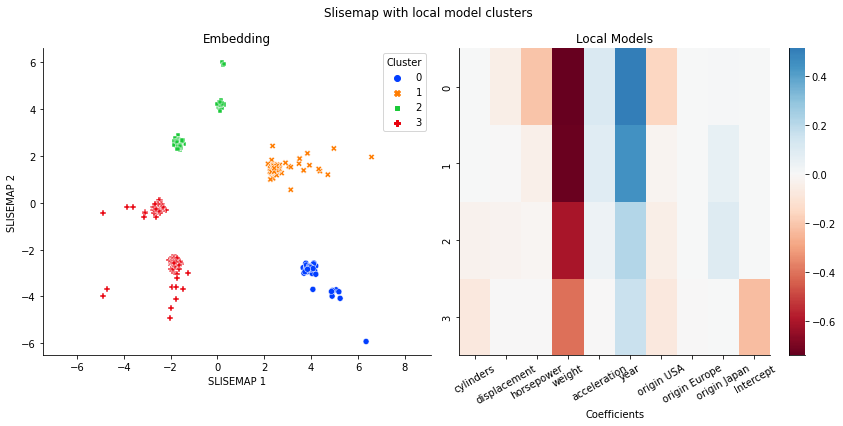

In [10]:
clusters = 4
sm.plot(
    title="Slisemap with local model clusters",
    clusters=clusters,
    jitter=0.1,
    variables=names,
)

Now we see that some points in the original embedding actually consisted of multiple points. This happens when the local models are identical. The matrix plot in the right panel correspond with the coefficients of the cluster means (i.e. the local linear model of the cluster means). Lets try plotting the local models in a bar plot instead:

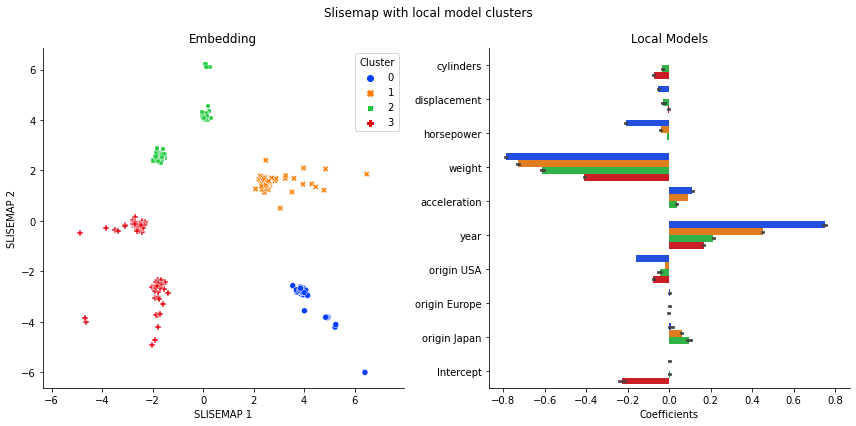

In [11]:
sm.plot(
    title="Slisemap with local model clusters",
    clusters=clusters,
    bars=True,
    jitter=0.1,
    variables=names,
)

We see that some variables are almost useless for all local models, so lets ignore them for now:

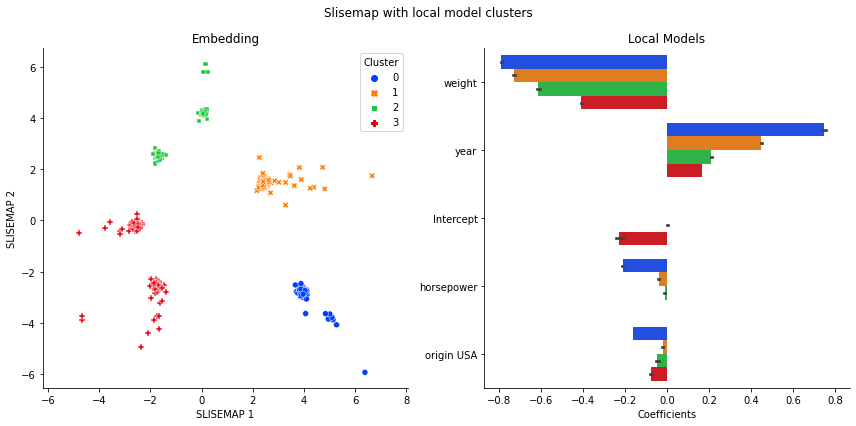

In [12]:
bars = 5
sm.plot(
    title="Slisemap with local model clusters",
    clusters=clusters,
    bars=bars,
    jitter=0.1,
    variables=names,
)

We can now identify which attributes play the most significant role within each cluster, i.e. which attributes in a given cluster are the most important in getting the predictions correct. The attributes contributing most negatively to fuel efficiency (when the values increase) are weight, horsepower and if the car originated from the USA. We also get one important positivily contributing attribute, which is the year the car was made (newer cars have better fuel efficiency).

Next we will take a more direct look at the distribution of attributes between the clusters. We use Slisemap inbuilt plotting script that utilises `seaborn.kdeplot` to produce density plots. Note that we unscaled the data to get more familiar values.

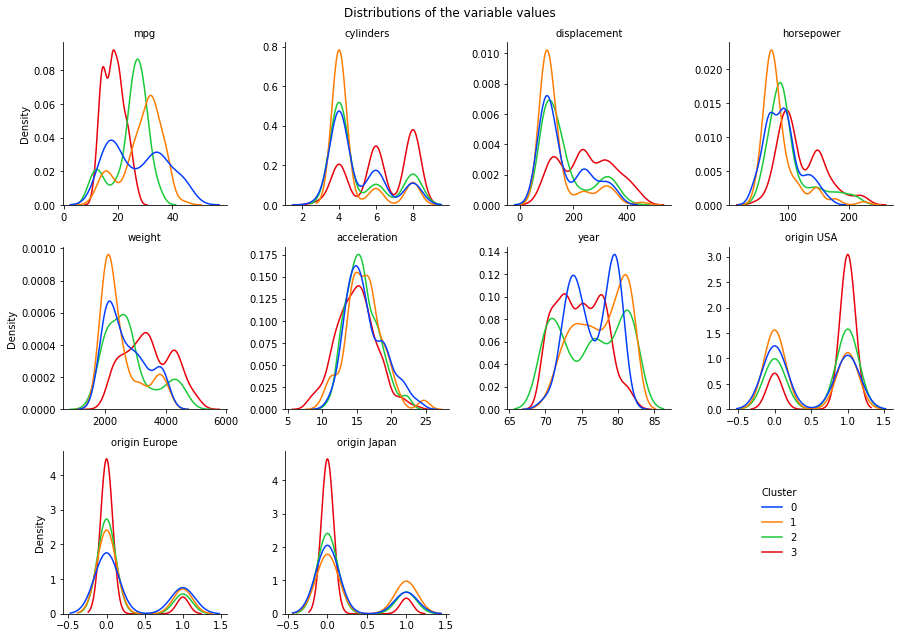

In [13]:
sm.plot_dist(
    X=X0,
    Y=y0,
    title="Distributions of the variable values",
    clusters=clusters,
    variables=names,
    targets="mpg",
    height=3,
)

We can now characterise the differences between, e.g., cluster 0 and cluster 3 more clearly. Focusing on the attributes we identified before. On average, cluster 0 contains lighter and newer cars with less horsepower, while cluster 3 contains heavy cars made in the USA. Notably, horsepower is *not* a factor explaining the predictions for cluster 3, and for cluster 0 the weight is the most dominant negative attribute. Also, the positive effect of the *year* attribute, on fuel consumption, has a different effect between the clusters.

### Investigating ambiguity

We also want to know how unique the clusters are, or if one data item could be placed in multiple clusters without loosing fidelity. For that purpose, Slisemap has yet another built-in plot:

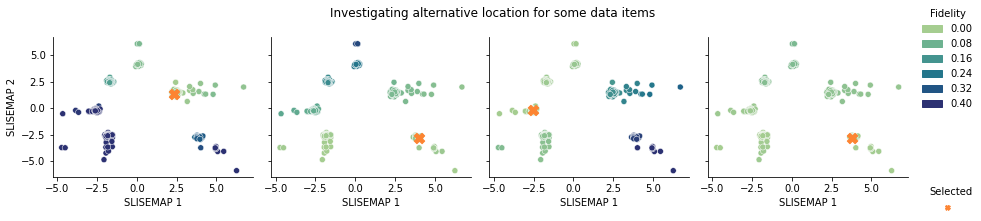

In [14]:
sm.plot_position(
    index=[350, 100, 300, 1],
    title="Investigating alternative location for some data items",
    height=3,
    jitter=0.1,
)

Here we have four plots, where we have taken a point in the embedding (marked) and then calculate what would be the fidelity of that point if it would be projected on top of one of the other points in the embedding. Some overlap between the local models is expected, especially neighbouring (in the embedding) local models should be similar. This is what we see in the first two panels; good fidelity in the same cluster, but there are areas where the point cannot be projected. However, In the rightmost panel, the point could be nearly everywhere in the embedding (while maintaining a good fidelity). This highlights that the solutions of Slisemap are not unique. Changes in the environment, such as different random seeds can produce slightly different plots (when these "multi-cluster" points move around).

### Unseen data

We also investigate how new data items would be projected into the embedding and what their local white box models would be.
This can be useful for, e.g., speeding up large datasets via subsampling or detecting concept drift.

In [15]:
# These are examples on how to generate the embeddings and local models for new datapoints
y3 = random_forest.predict(X_test)
Z_test, B_test = sm.fit_new(X_test, y3)

Alternative, we can produce plots (similar to above) to see if there are multiple viable alternatives for embedding the new data items.

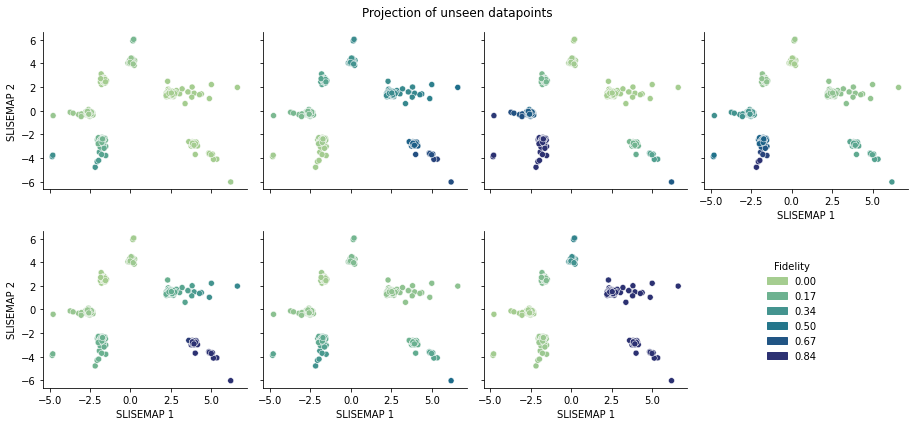

In [16]:
sm.plot_position(
    X_test, y3, title="Projection of unseen datapoints", height=3, jitter=0.1
)

## Conclusions

In this notebook we have looked at a simple use case for Slisemap, and demonstrated the various plots that can be used to to visualise, explore, and investigate the solution and the data.